Please wait for an illustrative plot to appear...


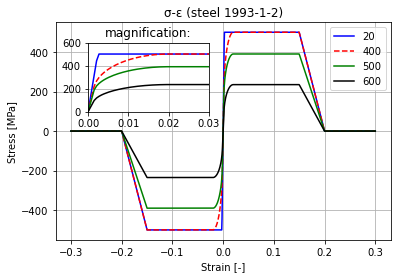

In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

""" *** STEEL *** """
steel_temp = [  20,  100,   200,   300,   400,   500,   600,   700,   800,    900  , 1000,   1100,  1200]
steel_ky   = [ 1.0,  1.0,   1.0,   1.0,   1.0,  0.78,  0.47,  0.23,  0.11,   0.06,   0.04,   0.02,  0.001]
steel_kp   = [ 1.0,  1.0, 0.807, 0.613, 0.420, 0.360, 0.180, 0.075, 0.050, 0.0375, 0.0250, 0.0125,  0.001]
steel_kE   = [ 1.0,  1.0,   0.9,   0.8,   0.7,   0.6,  0.31,  0.13,  0.09, 0.0675, 0.0450, 0.0225,  0.001]

steel_ky_interp = interp1d(steel_temp, steel_ky)
steel_kp_interp = interp1d(steel_temp, steel_kp)
steel_kE_interp = interp1d(steel_temp, steel_kE)


def sigma_steel(fy, temp, ε, printing_steel):
    E = 210*10**3  # MPa (N/mm2)
    ε_y = 0.02
    ε_t = 0.15
    ε_u = 0.20
    hardening = 0
    
    ky = steel_ky_interp(temp)
    kp = steel_kp_interp(temp)
    kE = steel_kE_interp(temp)
    
    fy_θ = ky * fy
    fp_θ = kp * fy
    E_θ = kE * E
    ε_p_θ = fp_θ / E_θ
    
    c = (fy_θ - fp_θ)**2 / ((ε_y - ε_p_θ) * E_θ - 2 * (fy_θ - fp_θ))
    a2 = (ε_y - ε_p_θ) * (ε_y - ε_p_θ + c / E_θ)
    a = a2**0.5
    b2 = c * (ε_y - ε_p_θ) * E_θ + c**2
    b = b2**0.5
    
    # ZNAKI:
    # Ta część kodu zwraca naprężenie dla wartości bezwględnej odkształcenia
    # Na końcu następuje zmiana znaku σ_s, w przypadku gdy ε < 0
    abs_ε = abs(ε)
    if abs_ε <= ε_p_θ:
        σ_s = abs_ε * E_θ
    elif abs_ε <= ε_y:
        σ_s = (fp_θ - c + (b/a) * (a2 - (ε_y - abs_ε) ** 2) ** 0.5) * (1 + abs_ε * hardening)
    elif abs_ε <= ε_t:
        σ_s = fy_θ * (1 + abs_ε * hardening)
    elif abs_ε <= ε_u:
        σ_s = fy_θ * (1 - (abs_ε - ε_t) / (ε_u - ε_t)) * (1 + ε_t * hardening)
    else:
        σ_s = 0  # for cases with strain > 20 %
        # raise Exception("WSz exception: strain in steel higher than the limit (usually 20%)")
    if ε < 0:
        σ_s = - σ_s
    else:
        pass
    # print("REINF: σ_s(ε=%.5f, θ=%.1f°C) = %.2f MPa" % (ε, temp, σ_s))
    if printing_steel == 'detailed':
        print("REINF: σ_s(fy = %.0f MPa, ε=%.5f (-), θ=%.1f °C) = %.2f MPa" % (fy, ε, temp, σ_s))
    else:
        pass
    return σ_s
v_sigma_steel = np.vectorize(sigma_steel, otypes=[float])


if __name__ == '__main__':
    # This block is only executed when the module is run directly
    # http://scipy-lectures.org/intro/language/reusing_code.html#main-and-module-loading
    # UNIT USE:
    # sigma_steel(500, 20, -0.003, 'detailed')
    #sigma_steel(500, 452.1, -0.02200, 'detailed')
    
    print('Please wait for an illustrative plot to appear...')
    
    # Vectorized USE:
    epsilons_test_steel = np.linspace(-0.3, 0.3, num=1000, endpoint=True)
    
    
    selected_temperatures = [20, 400, 500, 600]
    sigmas20 = v_sigma_steel(500, selected_temperatures[0], epsilons_test_steel, 'None')
    sigmasHIGH1 = v_sigma_steel(500, selected_temperatures[1], epsilons_test_steel, 'None')
    sigmasHIGH2 = v_sigma_steel(500, selected_temperatures[2], epsilons_test_steel, 'None')
    sigmasHIGH3 = v_sigma_steel(500, selected_temperatures[3], epsilons_test_steel, 'None')
    
    # PLOT:
    plt.plot(epsilons_test_steel, sigmas20, color='blue', label=selected_temperatures[0])
    plt.plot(epsilons_test_steel, sigmasHIGH1, color='red', linestyle='--', label=selected_temperatures[1])
    plt.plot(epsilons_test_steel, sigmasHIGH2, color='green', label=selected_temperatures[2])
    plt.plot(epsilons_test_steel, sigmasHIGH3, color='black', label=selected_temperatures[3])
    plt.title('σ-ε (steel 1993-1-2)')
    plt.xlabel('Strain [-]')
    plt.ylabel('Stress [MPa]')
    plt.grid(b=True, which='major', axis='both')
    plt.legend()
    
    # ADD PLOT WITHIN PLOT:
    # https://stackoverflow.com/a/44885788
    # location for the zoomed portion 
    sub_axes = plt.axes([.2, .57, .28, .24])  # position: X, Y; scale: X, Y
    # plot the zoomed portion
    sub_axes.plot(epsilons_test_steel, sigmas20, color='blue') 
    sub_axes.plot(epsilons_test_steel, sigmasHIGH1, color='red', linestyle='--')
    sub_axes.plot(epsilons_test_steel, sigmasHIGH2,  color='green')
    sub_axes.plot(epsilons_test_steel, sigmasHIGH3, color='black')
    plt.title('magnification:')
    plt.xlim(0, 0.03)
    plt.ylim(0, 600)
    plt.grid(b=True, which='major', axis='both')
    plt.rcParams["figure.dpi"] = 1200  # https://stackoverflow.com/a/61674354
    plt.show()
    
    #import sys
    #eps_sigma = np.vstack((epsilons_test2, sigmas20))
    #np.savetxt(sys.stdout, np.transpose(eps_sigma), fmt="%.5f", delimiter=', ')


def single_plot(temperature1):
    print('Please wait for the plot to appear...')
    epsilons_test_steel = np.linspace(-0.3, 0.3, num=1000, endpoint=True)
    sigmasHIGH1 = v_sigma_steel(500, temperature1, epsilons_test_steel, 'None')
    plt.plot(epsilons_test_steel, sigmasHIGH1, color='red', linestyle='--', label=temperature1)
    plt.title('σ-ε (steel 1993-1-2)')
    plt.xlabel('Strain [-]')
    plt.ylabel('Stress [MPa]')
    plt.grid(b=True, which='major', axis='both')
    plt.legend()
    
    # ADD PLOT WITHIN PLOT:
    # https://stackoverflow.com/a/44885788
    # location for the zoomed portion 
    sub_axes = plt.axes([.2, .57, .28, .24])  # position: X, Y; scale: X, Y
    # plot the zoomed portion
    sub_axes.plot(epsilons_test_steel, sigmasHIGH1, color='red', linestyle='--')
    plt.title('magnification:')
    plt.xlim(0, 0.03)
    plt.ylim(0)
    plt.grid(b=True, which='major', axis='both')
    plt.rcParams["figure.dpi"] = 600  # https://stackoverflow.com/a/61674354
    plt.show()

##
import ipywidgets
style = {'description_width': 'initial'}
# Description length: https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Styling.html#Description

temp_plot_widget = ipywidgets.BoundedFloatText(
    value=500,
    min=0,
    max=1200.0,
    step=10,
    description='Plot chart for this temperature (°C):',
    style=style, 
    disabled=False)
fy_ipy = ipywidgets.BoundedFloatText(
    value=500,
    min=0,
    max=1000.0,
    step=10,
    description='Yield strength of steel (MPa):',
    style=style, 
    disabled=False)
temp_ipy = ipywidgets.BoundedFloatText(
    value=20,
    min=0,
    max=1200.0,
    step=10,
    description='Temperature of steel (°C):',
    style=style, 
    disabled=False)
eps_ipy = ipywidgets.BoundedFloatText(
    value=0.02,
    min=0,
    max=20.0,
    step=0.001,
    description='Strain of steel (-):',
    style=style, 
    disabled=False)